# Amazing Altair with an even better theme

Daniel Kapitan  
2024-01-21

I have been in love with Altair ever since I first ran into it. The
logic, the structure, the syntax: it’s all just there and it helps me to
get my work done. Paired with [Quarto](https://quarto.org) or
[Streamlit](https://streamlit.io), I can create stunning pdf reports,
interactive documents and single-page apps for my clients, all from one
codebase. After attending a workshop by my fellow data viz afficianado
[Sara Sprinkhuizen](https://www.thedatavisionlab.com/), I wanted to
implement her tried-and-tested best practices for charts into an Altair.

In this post, we will illustate how these improvements work for a
handful of visualizations that are often used for exploratory data
analysis. We will implement her design principles in an Altair theme,
such that we can consistently generate better charts in our workflow.
Let’s start and see how Altair’s default theme renders a scatterplot,
bar chart and line chart.

In [1]:
import altair as alt
import ibis
from vega_datasets import data


ibis.options.interactive = True

penguins = ibis.examples.penguins.fetch()
stocks = data.stocks()
wheat = data.wheat()

## Scatterplot

A scatterplot is one of the most commonly used visualizations. In this
case we encode three values for the [Palmer penguins
data](https://allisonhorst.github.io/palmerpenguins/): bill length
vs. bill depth, per species. The only optimization we apply is to have
the axis not go all the way to zero, so the charts is focused on the
actual datapoints.

In [2]:
scatterplot = (
    alt.Chart(penguins)
    .mark_circle(size=60)
    .encode(
        x=alt.X("bill_length_mm:Q", scale=alt.Scale(zero=False)),
        y=alt.Y("bill_depth_mm:Q", scale=alt.Scale(zero=False)),
        color=alt.Color("species"),
        tooltip=["species", "sex", "island", "bill_length_mm:Q", "bill_depth_mm:Q"],
    )
)
scatterplot

## Bar chart

Next up is the trusty ol’ bar chart, which we demonstrate using the
wheat dataset. This chart is challenging because it spans two and a half
centuries of yearly data, leading to a wide chart with the default
settings. Did you turn your head to read the year labels on the x-axis?
Or to figure out that the y-axis title reads `wheat`? Surely there must
be a better way.

In [3]:
barchart = (
    alt.Chart(wheat)
    .mark_bar()
    .encode(x="year:O", y="wheat:Q", tooltip=["year:O", "wheat:Q"])
)
barchart

## Line chart

A line chart with a legend, in this case showing stock prices of a
handful of tech companies, is also something we use on a regular basis.
Did you even notice the effort you have to put in to lookup the color of
the line in the legend? I actually had a hard time distinguishing Amazon
and Google, as the red and orange are very alike to my eyes.

In [4]:
chart = alt.Chart(stocks).encode(color=alt.Color("symbol"))
line = chart.mark_line().encode(
    x=alt.X("date:T", axis=alt.Axis(title="date")),
    y=alt.Y("price:Q", axis=alt.Axis(title="price")),
    tooltip=["date", "price"],
)
line

## Some simple but sensible design principles

Sara’s main points for improving the standard layout of charts basically
boil down to the following princples:

-   **use informative action titles and subtitles**: much like effective
    presentations, using so-called [action
    titles](https://slideworks.io/resources/how-to-write-action-titles-like-mckinsey)
    will greatly increase the impact of your data visualization.
    Formulated as a short, simple sentence, action titles should ideally
    be the main takeaway or ‘so what’ of the chart, and – if done right
    – allows the audience to only read the title to understand the
    primary message of the visual.
-   **less is more**: before minimalism became all the rage in design,
    Edward Tufte coined the principle of [maximizing the data-to-ink
    ratio](https://infovis-wiki.net/wiki/Data-Ink_Ratio). Charts are
    easier to read by removing unnecessary clutter. So get rid of
    gridlines, background colors and the like.
-   **keep it horizontal**: text is easier to read when it is
    horizontally aligned. So straighten up those rotated x-axis labels
    and y-axis titles
-   **lose the legends**: having to lookup colors increases the
    cognitive load of reading a chart. Use annotations instead.

All these principles can be readily implemented in Altair. Sergio
Sánchez in fact captured the first three principles when implementing
the Urban Institute styleguide (shown below) as [an Altair
theme](https://towardsdatascience.com/consistently-beautiful-visualizations-with-altair-themes-c7f9f889602).

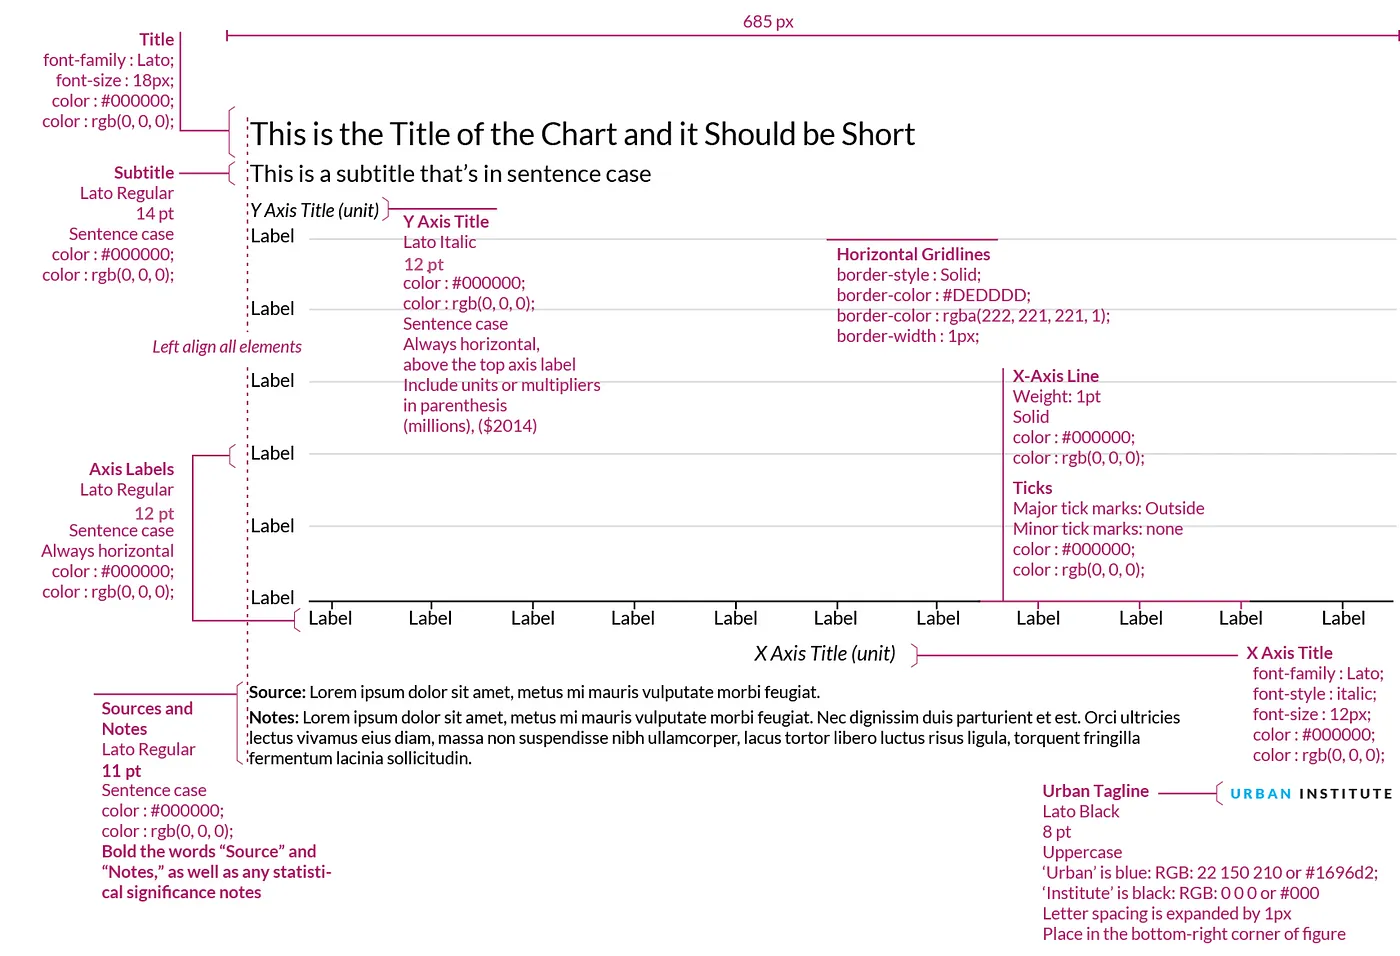

Building on his work, we created our on theme called **Okabe Ito**, in
honour of their work in defining [colorblind-safe color
palettes](https://thenode.biologists.com/data-visualization-with-flying-colors/research/).
Not only is it functional, but I really like the muted colors, too.
Below is a visual from their [original
paper](https://jfly.uni-koeln.de/color/) that also shows how different
types of colorblindness (protan, deutan, tritan) results in different
perception of the colors.

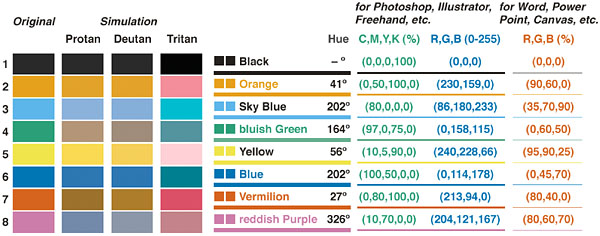

To use this template, download
[okabe-ito-theme.py](../resources/okabe-ito-theme.py), put it in the
same folder as your notebook and at the following two cells.

To register the template as an Altair theme:

In [5]:
%run ../resources/okabe-ito-theme.py

To download the fonts used in the template:

In [6]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Lato');
</style>

Let’s see how this changes the charts.

### Adding titles

The theme automatically has been configured to improve the data-to-ink
ratio and align all texts horizontally. Adding action titles can be done
using
[`alt.TitleParams`](https://altair-viz.github.io/user_guide/customization.html#adjusting-the-title),
with which you can not only add a title, but also add multiple subtitles
lines which you pass as a list.

In [7]:
(
    scatterplot.properties(
        title=alt.TitleParams(
            "Bill length vs. bill depth", subtitle=["Did you spot Simpson's Paradox?"]
        )
    )
)

### Everything horizontal

The effect of aligning all text horizontally is a significant
improvement on the bar chart, which is now much easier to read. Adding a
two-line subtitle make the action title even more compelling. Using
`alt.mark_text()` we can easily add footnotes as well, in this case to
provide references to the claim.

In [8]:
footnote = alt.Chart(wheat).mark_text(
    text="*Source: https://en.wikipedia.org/wiki/British_Agricultural_Revolution",
    color="#000000",
    x=0,
    y="height",
    dy=60,
    align="left",
)

alt.layer(barchart, footnote).properties(
    title=alt.TitleParams(
        "What's Up With Wheat",
        subtitle=[
            "An example of the impact of the agricultural revolution",
            "Productivity increased through mechanization*",
        ],
    ),
)

### Lose the legends

Although legends are fine for exploratory data analysis, where you don’t
want to spend too much time tweaking your charts, for explanatory data
analysis we want to make it as easy on the reader as possible.
Unforunately, I couldn’t find a way to add annotations (instead of a
legend) using Altair’s theming engine. Here’s a first shot by
implementing it manually.

In [9]:
chart = alt.Chart(stocks).encode(color=alt.Color("symbol", legend=None))
line = chart.mark_line().encode(
    x=alt.X("date:T", axis=alt.Axis(title="date")),
    y=alt.Y("price:Q", axis=alt.Axis(title="price")),
    tooltip=["date", "price"],
)
label = chart.encode(
    x=alt.X("date:T", aggregate="max"),
    y=alt.Y("price:Q", aggregate={"argmax": "date"}),
    text="symbol",
)
text = label.mark_text(align="left", dx=4)
circle = label.mark_circle()
(
    (line + circle + text).configure_axisX(labelAngle=0, ticks=False)
    # .configure_axisY(titleAngle=0, titleAlign="center", titleX=-10, titleY=-10)
).properties(
    width=600,
    title=alt.TitleParams(
        "The Rise of Google",
        subtitle=[
            "Google went public in 2004",
            "and outperformed other tech stocks until 2010",
        ],
    ),
)

I could go on for hours, tweaking this and that. For example, the labels
in the last chart overlap. Vega has the [label
transform](https://vega.github.io/vega/docs/transforms/label/) method to
deal with that, but that implementation still needs to cascade down to
Vega-Lite and Altair. Someday, I will package all this as a proper
theme, re-using
[feedzai’s](https://github.com/feedzai/feedzai-altair-theme) code.